In [31]:
import pandas as pd
import numpy as np
import sqlite3

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [38]:
connect = sqlite3.connect("../db.sqlite3")
df = pd.read_sql("SELECT restaurant_order.datetime, restaurant_orderitem.quantity, restaurant_product.price, restaurant_product.name FROM restaurant_order INNER JOIN restaurant_orderitem ON restaurant_orderitem.order_id=restaurant_order.id INNER JOIN restaurant_product ON restaurant_orderitem.product_id=restaurant_product.id", connect)

df["datetime"] = pd.to_datetime(df["datetime"])
df

,datetime,quantity,price,name
0,2019-08-03 20:25:00,2,0.80,Plain Papadum
1,2019-08-03 20:25:00,1,12.95,King Prawn Balti
2,2019-08-03 20:25:00,1,2.95,Garlic Naan
3,2019-08-03 20:25:00,1,3.95,Mushroom Rice
4,2019-08-03 20:25:00,1,8.95,Paneer Tikka Masala
...,...,...,...,...
74813,2016-05-18 18:53:00,2,17.95,House Red wine 75cl
74814,2016-05-14 19:28:00,2,17.95,House Red wine 75cl
74815,2016-05-10 13:18:00,2,17.95,House Red wine 75cl
74816,2016-04-07 19:04:00,1,17.95,House white wine 75cl


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

<Axes: title={'center': 'Top 10 positions in menu by quantity'}, ylabel='Quantity'>

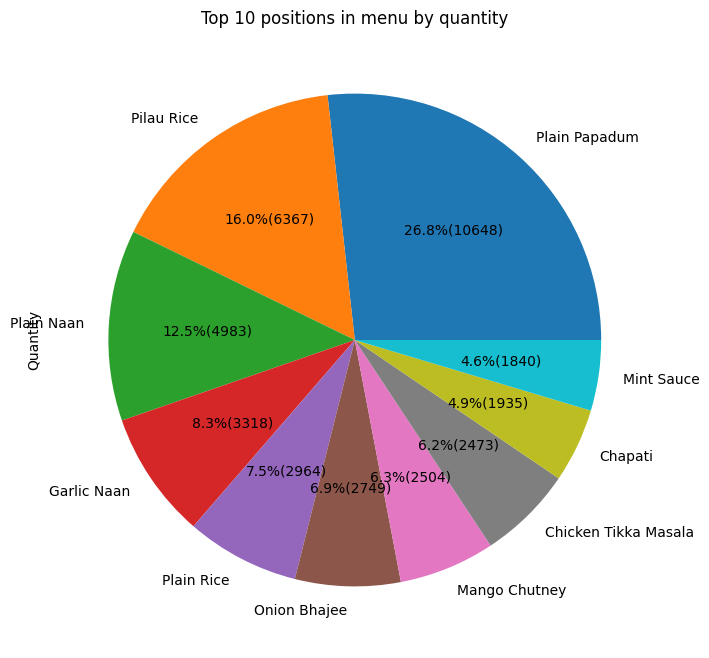

In [39]:
top_products = df.groupby("name")["quantity"].sum().sort_values(ascending=False).iloc[:10]
top_products.plot(kind="pie", title="Top 10 positions in menu by quantity", ylabel="Quantity", figsize=[8,8], 
                  autopct=lambda p:"{:.1f}%({:.0f})".format(p,(p/100) * top_products.sum()))

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

<Axes: title={'center': 'Top 10 positions in menu by earned money'}, ylabel='Earned'>

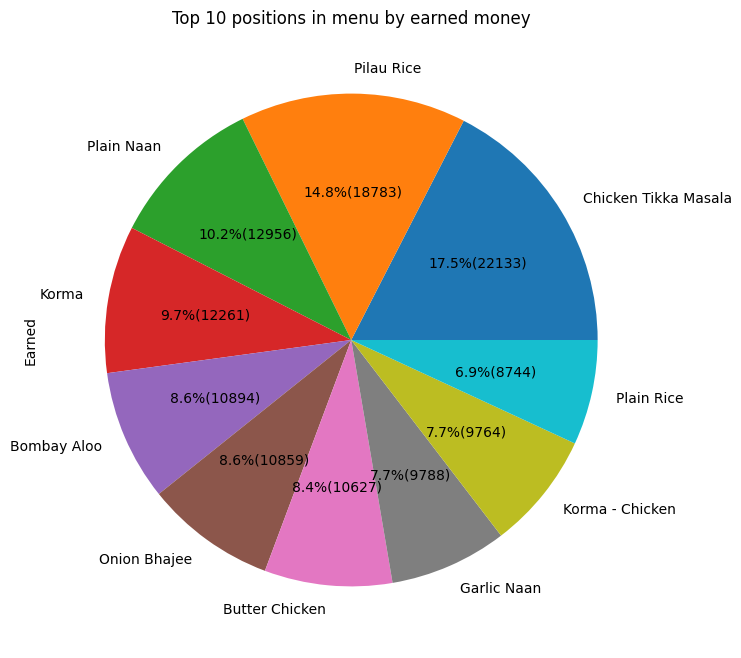

In [40]:
df["Earned"] = df["price"] * df["quantity"]
top_price_products = df.groupby("name")["Earned"].sum().sort_values(ascending=False).iloc[:10]
top_price_products.plot(kind="pie", title="Top 10 positions in menu by earned money", ylabel="Earned", figsize=[8,8], 
                        autopct=lambda p:"{:.1f}%({:.0f})".format(p,(p/100) * top_price_products.sum()))

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

<Axes: title={'center': 'Profit by Order Hour'}, xlabel='Order Hour'>

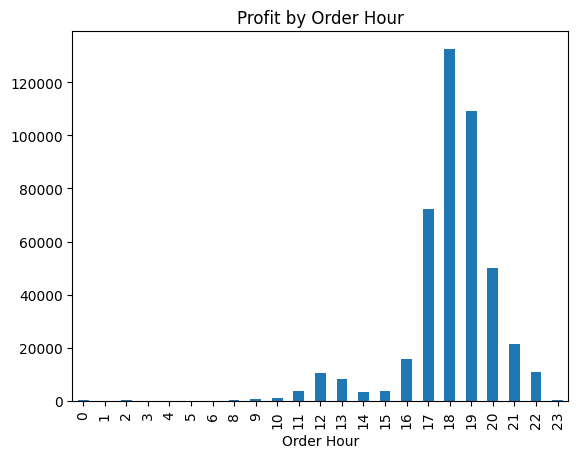

In [41]:
df["datehour"] = df["datetime"].dt.hour
hour_df = df.groupby("datehour")["Earned"].sum()
hour_df.plot.bar(title="Profit by Order Hour", xlabel="Order Hour")

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

<Axes: title={'center': 'Profit by Order Day Of The Week'}, xlabel='Order Day Of The Week'>

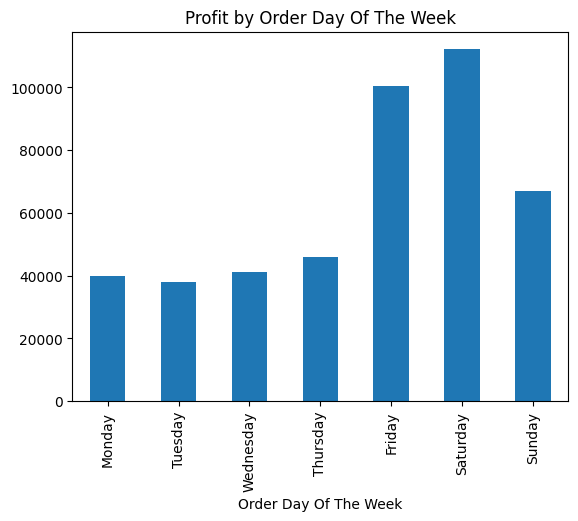

In [42]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["day_name"] = df["datetime"].dt.day_name()
day_df = df.groupby("day_name")["Earned"].sum().reindex(days)
day_df.plot.bar(title="Profit by Order Day Of The Week", xlabel="Order Day Of The Week")